# Data Reduction & Produce Science Image

Modified from [https://github.com/Project-Dinos/dinos-i/blob/main/1_HST_lens_processing/3_Pre-Processor.ipynb]

This requires:

1) AstroObjectAnalyzer [https://github.com/sibirrer/AstroObjectAnalyser/tree/master]
2) AstroFunc [https://github.com/sibirrer/astrofunc]
3) CosmoHammer [https://github.com/cosmo-ethz/CosmoHammer]
4) Pyextract [https://github.com/AdrianSchlegel/Pyextract]
5) Source Extractor [https://anaconda.org/conda-forge/astromatic-source-extractor]

In [ ]:
import glob
import os
import shutil

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from astroObjectAnalyser.astro_object_superclass import StrongLensSystem

In [ ]:
def InitiateSystem(name, filter, ra, dec, ra_cutout_cent=None, dec_cutout_cent=None):
    """initialize a Strong Lens System with relevant image and weight data"""

    # define the folder containing reduced data
    reduced_data_folder = '../reduced_data'
    # path to the reduced data for the specified name and filter
    path2reduced_data = f'{reduced_data_folder}/{name}_reduced/{filter}'
    
    # create an instance of StrongLensSystem
    system = StrongLensSystem(name)
    
    # determine file names based on the filter type
    if filter == 'F160W':
        img_file = f'{name}_{filter}_drz_sci.fits'  # science image file for F160W
        wht_file = f'{name}_{filter}_drz_wht.fits'  # weight file for F160W
    else:
        img_file = f'{name}_{filter}_drc_sci.fits'  # science image file for other filters
        wht_file = f'{name}_{filter}_drc_wht.fits'  # weight file for other filters
    
    # full paths to image and weight data
    path2img_data = os.path.join(path2reduced_data, img_file)
    path2wht_data = os.path.join(path2reduced_data, wht_file)
    
    # set cutout center coordinates if not provided
    if ra_cutout_cent is None:
        ra_cutout_cent = ra
    if dec_cutout_cent is None:
        dec_cutout_cent = dec
    
    # add image data to the system instance with cutout and other parameters
    system.add_image_data_init(filter, path2img_data, local_wht_filename=path2wht_data, 
                               cutout_scale=100, data_type='HST_new', 
                               ra=ra, dec=dec, 
                               ra_cutout_cent=ra_cutout_cent, dec_cutout_cent=dec_cutout_cent)
    return system

def PreProcess(name, filter, ra, dec, ra_cutout_cent=None, dec_cutout_cent=None, 
               display_img=True, remove_sex_cat=False):
    """preprocess the system by creating cutouts, displaying images, and saving data"""

    # initialize the system
    system = InitiateSystem(name, filter, ra, dec, ra_cutout_cent, dec_cutout_cent)
    
    # define folders for cutout data
    cutout_data_folder = '../reduced_data/cutout_data'
    path2cutout_data = os.path.join(cutout_data_folder, name, filter)
    
    # define path to original science data file
    if filter == 'F160W':
        path2original_data = f'../reduced_data/{name}_reduced/{filter}/{name}_{filter}_drz_sci.fits'
    else:
        path2original_data = f'../reduced_data/{name}_reduced/{filter}/{name}_{filter}_drc_sci.fits'
    
    # get a cutout image (default 100 scale, reduced to 60 for F160W)
    img_cutout = system.get_cutout_image(filter, 100, force=True)
    if filter == 'F160W':
        img_cutout = system.get_cutout_image(filter, 60, force=True)
    
    # calculate background mean and sigma (RMS)
    mean_bkd, sigma_bkd = system.get_background(filter)
    # reduce the cutout image by subtracting the background
    img_cutout_reduced = img_cutout - mean_bkd
    
    # display the science image
    plt.imshow(np.log10(img_cutout_reduced), cmap='cubehelix', origin='lower')
    plt.title(name, size=22)
    
    # ensure cutout data folder exists, create if not
    if not os.path.isdir(path2cutout_data):
        os.makedirs(path2cutout_data)
    
    # save the reduced cutout as a FITS file
    SaveCutoutAsFits(path2original_data, name, filter, img_cutout_reduced, sigma_bkd)
    
    # copy a SExtractor catalog file to the cutout data directory
    path2sexcat = os.path.join(path2cutout_data, f'pysex_{name}_{filter}.cat')
    shutil.copyfile('./.pysex.cat', path2sexcat)
    
    # optionally remove SExtractor catalog files after processing
    if remove_sex_cat:
        for file in glob.glob('./.pysex*'):
            os.remove(file)

def SaveCutoutAsFits(original_fits_path, name, filter, img_cutout_reduced, sigma_bkd):
    """save the cutout image as a FITS file"""

    # define output directory and filename
    output_dir = '../reduced_data/cutout_data'
    cutout_fits_filename = f'{name}_{filter}_cutout.fits'
    path_to_fits = os.path.join(output_dir, name, filter, cutout_fits_filename)
    
    # ensure the output directory exists
    if not os.path.isdir(os.path.dirname(path_to_fits)):
        os.makedirs(os.path.dirname(path_to_fits))
    
    # open the original FITS file, replace data with reduced cutout, and save
    with fits.open(original_fits_path) as hdul:
        hdul[0].data = img_cutout_reduced 
        hdul[0].header['BACK_RMS'] = (sigma_bkd, 'Background RMS')  # Add RMS info to header
        hdul.writeto(path_to_fits, overwrite=True)
    
    print(f'Cutout FITS file saved to: {path_to_fits}')


the center of the image is at pixel coordinates 2241.923352, 3553.785911.
ccd gain = 1.5
No filter file found, using default filter
No NNW file found, using default NNW config
sextractor command: sex ../reduced_data/J2325-5229_reduced/F814W/J2325-5229_F814W_drc_sci.fits -c .pysex.sex -GAIN 2142.0 -CATALOG_NAME .pysex.cat -PARAMETERS_NAME .pysex.param -FILTER_NAME .pysex.conv -STARNNW_NAME .pysex.nnw


> 
----- SExtractor 2.28.0 started on 2025-03-09 at 20:28:53 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for J2325-5229_F814W_drc_sci.fits
----- Measuring from: J2325-5229_F814W_drc_sci.fits [0/2]
      "Unnamed" / no ext. header / 4880x5080 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   64
> Setting up background map at line:  128
> Setting up background map at line:  192
> Setting up background map at line:  256
> Setting up background map at line:  320
> Setting up background map at line:  384
> Setting up background map at line:  448
> Setting up background map at line:  512
> Setting up background map at line:  576
> Setting up background map at line:  640
> Setting up background map at line:  704
> Setting up background map at line:  768
> Setting up background map at line:  832
> Setting up

Cutout FITS file saved to: ../reduced_data/cutout_data/J2325-5229/F814W/J2325-5229_F814W_cutout.fits


> Line: 4525  Objects:     6444 detected /     4315 sextracted
> Line: 4550  Objects:     6463 detected /     4347 sextracted
> Line: 4575  Objects:     6480 detected /     4369 sextracted
> Line: 4600  Objects:     6493 detected /     4399 sextracted
> Line: 4602  Objects:     6494 detected /     4400 sextracted
> Line: 4625  Objects:     6503 detected /     4433 sextracted
> Line: 4650  Objects:     6521 detected /     4462 sextracted
> Line: 4675  Objects:     6543 detected /     4488 sextracted
> Line: 4700  Objects:     6555 detected /     4517 sextracted
> Line: 4725  Objects:     6567 detected /     4550 sextracted
> Line: 4750  Objects:     6588 detected /     4577 sextracted
> Line: 4775  Objects:     6603 detected /     4611 sextracted
> Line: 4800  Objects:     6609 detected /     4641 sextracted
> Line: 4825  Objects:     6613 detected /     4643 sextracted
> Line: 4850  Objects:     6622 detected /     4643 sextracted
> Line: 4875  Objects:     6630 detected /     4643 sex

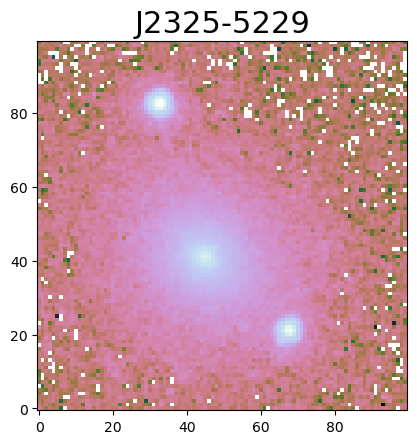

In [3]:
object_name = 'J2325-5229'
filter = 'F814W'

if filter == 'F160W':
    type = 'drz'
else:
    type = 'drc'

rerun_preprocess = True

# get ra and dec from image
with fits.open(f'../reduced_data/{object_name}_reduced/{filter}/{object_name}_{filter}_{type}_sci.fits') as hdu:
    sci_header = hdu[0].header
    ra_targ = sci_header['ra_targ']
    dec_targ = sci_header['dec_targ']

if rerun_preprocess:
    PreProcess(object_name, filter, ra_targ, dec_targ, ra_targ - 0.4/3600, dec_targ + 0.15/3600, remove_sex_cat=True)